<a href="https://colab.research.google.com/github/HarshitJhawar/nifty-volatility-forecasting-with-lstm-garch/blob/main/Time_Series_Prediction_on_Nifty50_Daily_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
%pip install arch
%pip install seaborn
!pip install -U statsmodels
from itertools import product
from random import gauss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install yfinance
import yfinance as yf
from datetime import date, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from arch import arch_model
from packaging import version

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))

Num GPUs Available: 0


In [ ]:
total_df = pd.read_csv("/content/drive/MyDrive/Datasets /Algobulls /NIFTY 50_daily_data.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
total_df = total_df.drop(["volume","open", "high", "low"], axis=1)
total_df['datetime'] = pd.to_datetime(total_df['date'])
# Split into two new columns
total_df['date'] = total_df['datetime'].dt.date
total_df['time'] = total_df['datetime'].dt.time
total_df = total_df.drop(["datetime", "time"], axis=1)
total_df.set_index('date', inplace=True)
total_df['ClosePrediction'] = total_df['close'].shift(1)
total_df

,close,ClosePrediction
date,,
2015-01-01,8284.00,NaN
2015-01-02,8395.40,8284.00
2015-01-05,8378.40,8395.40
2015-01-06,8127.30,8378.40
2015-01-07,8102.10,8127.30
...,...,...
2025-02-03,23361.05,23482.15
2025-02-04,23739.25,23361.05
2025-02-05,23696.30,23739.25


# Starting afresh: Broad spectrum of models and their metrics

1.   Naive forecasting
2.   simple model - 1 step output
4. multi-output  forecast (GlobalMaxPooling and Dense Layers)
  4.1. best model
5. multioutput with 2 LSTMs



Baseline Model - Naive Forecasting
---
Naive Forecasting serves as a baseline model for all the following models. Naive forecasting is where you just shift the previous day's values as your prediction.

In [ ]:
y_true = total_df.iloc[1:]['close']
y_pred = total_df.iloc[1:]['ClosePrediction']

In [ ]:
def sMAPE(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
smape_score = sMAPE(y_true, y_pred)
sse = np.sum((y_true - y_pred)**2)

# Create a DataFrame for the results
metrics_data = {
    'Metric': ['MAE', 'R2 Score', 'MAPE (%)', 'sMAPE (%)', 'SSE'],
    'Value': [mae, r2, mape * 100, smape_score, sse] # Multiply MAPE by 100 for percentage
}
metrics_naive_df = pd.DataFrame(metrics_data)

# Format the 'Value' column as decimal
metrics_naive_df['Value'] = metrics_naive_df['Value'].apply(lambda x: f'{x:.4f}')

# Display the table
print("Metrics for Naive Forecasting - which will act as baseline model")
print(metrics_naive_df.to_string(index=False))

Metrics for Naive Forecasting - which will act as baseline model
   Metric         Value
      MAE       92.8873
 R2 Score        0.9993
 MAPE (%)        0.7082
sMAPE (%)        0.7076
      SSE 46512072.4743


N = no of samples
T = sequence length
D = no of input features
M = no of hidden units
K = no of output units

# 1. Simple LSTM-based Model

In [ ]:
df = total_df.copy()
df = df.drop(["ClosePrediction"], axis=1)
df["LogClose"] = np.log(df["close"])
df["DiffLogClose"] = df["LogClose"].diff()
df

,close,LogClose,DiffLogClose
date,,,
2015-01-01,8284.00,9.022081,NaN
2015-01-02,8395.40,9.035439,0.013358
2015-01-05,8378.40,9.033412,-0.002027
2015-01-06,8127.30,9.002984,-0.030428
2015-01-07,8102.10,8.999879,-0.003105
...,...,...,...
2025-02-03,23361.05,10.058825,-0.005170
2025-02-04,23739.25,10.074885,0.016060
2025-02-05,23696.30,10.073074,-0.001811


In [ ]:
no_test = 250
train = df.iloc[:-no_test]
test = df.iloc[-no_test:]

In [ ]:
#booolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
df

,close,LogClose,DiffLogClose
date,,,
2015-01-01,8284.00,9.022081,NaN
2015-01-02,8395.40,9.035439,0.013358
2015-01-05,8378.40,9.033412,-0.002027
2015-01-06,8127.30,9.002984,-0.030428
2015-01-07,8102.10,8.999879,-0.003105
...,...,...,...
2025-02-03,23361.05,10.058825,-0.005170
2025-02-04,23739.25,10.074885,0.016060
2025-02-05,23696.30,10.073074,-0.001811


In [ ]:
series = df["DiffLogClose"].dropna().to_numpy()
series

array([ 0.01335799, -0.00202697, -0.0304282 , ..., -0.00181088,
       -0.00393027, -0.00184041])

We are running hyperparameter tuning for this model

100%|██████████| 6/6 [05:18<00:00, 53.12s/it]



Top models based on final validation loss:
 T  LSTM_units loss_fn  val_loss
20          24   huber  0.000039
20          32   huber  0.000039
30          32   huber  0.000039
20          32     mse  0.000077
20          24     mse  0.000077
30          32     mse  0.000077


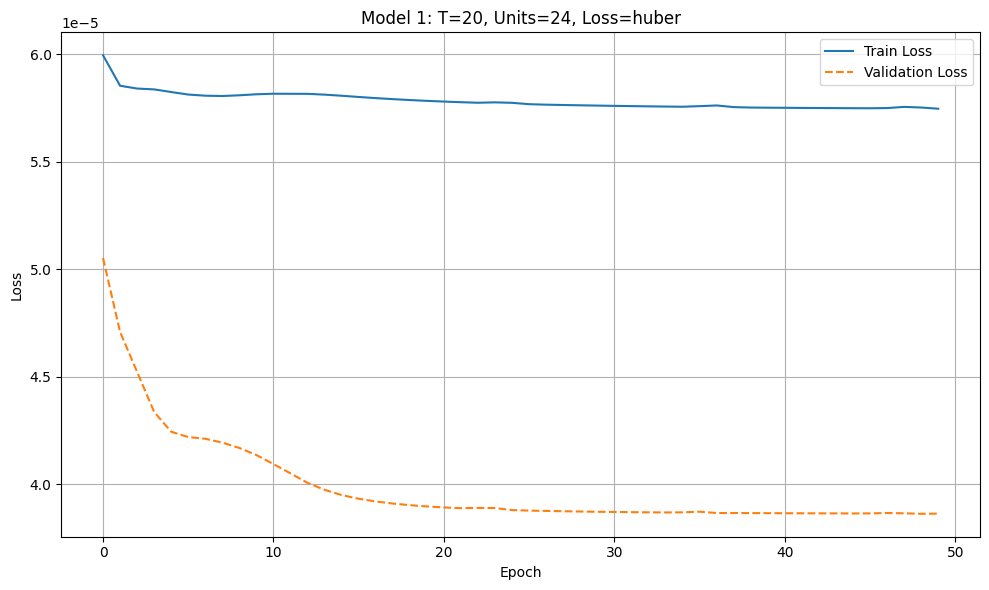

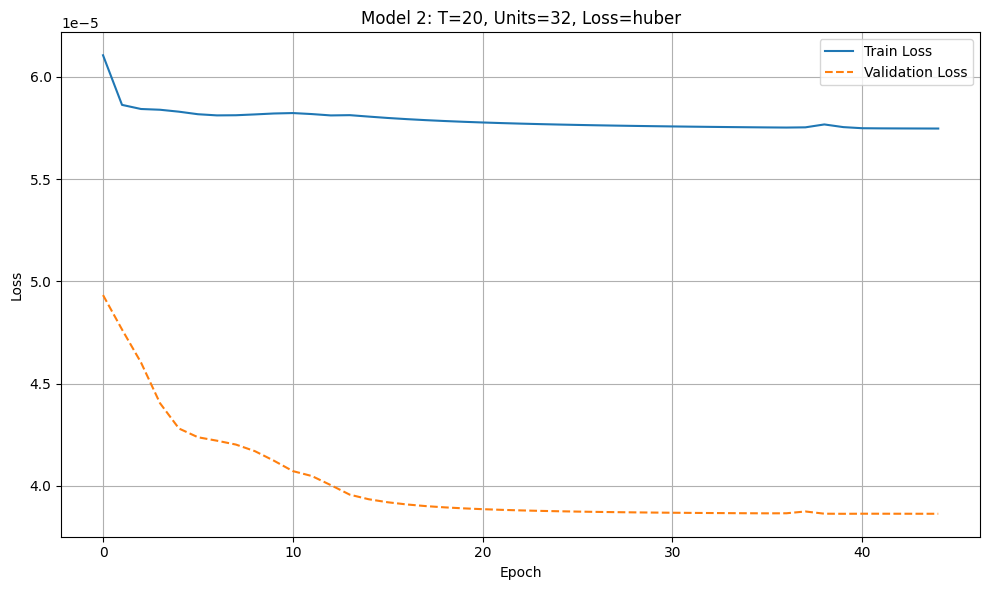

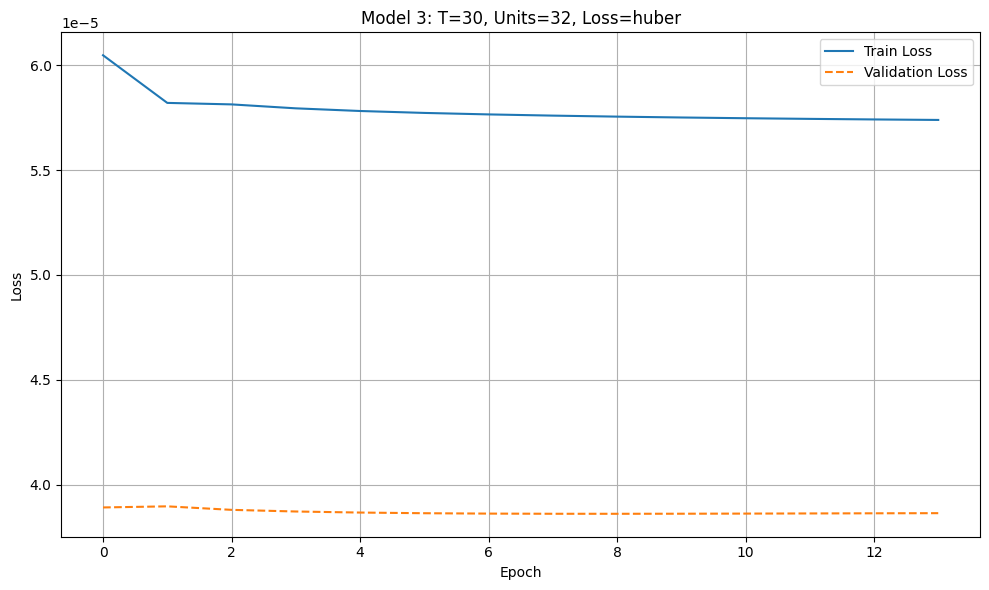

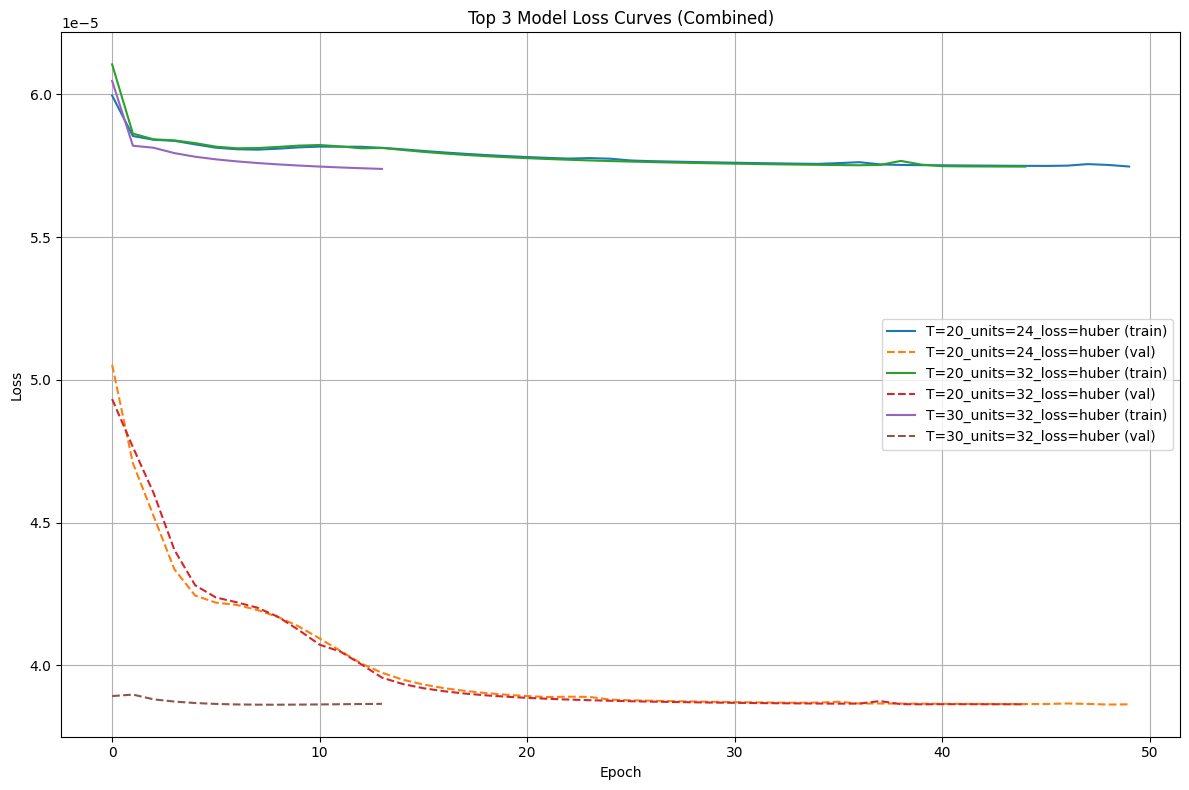

In [ ]:
# 1. Function to generate input/output data
def generate_dataset(series, T):
    X, Y = [], []
    for t in range(len(series) - T):
        x = series[t:t+T]
        y = series[t+T]
        X.append(x)
        Y.append(y)
    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y)
    return X, Y

# 2. Function to build model
def build_model(T, units, loss_fn):
    model = Sequential([
        Input(shape=(T, 1)),
        LSTM(units),
        Dense(1)
    ])

    if loss_fn == 'mse':
        loss = 'mse'
    elif loss_fn == 'huber':
        loss = Huber()

    model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

# 3. Grid configuration
param_grid = [
    (20, 24, 'huber'), (20, 32, 'huber'), (20, 24, 'mse'), (20, 32, 'mse'),
    (30, 32, 'huber'), (30, 32, 'mse')
    ]

results = []
history_dict = {}

# 4. Grid Search Loop
for T, units, loss_fn in tqdm(param_grid):
    X, Y = generate_dataset(series, T)

    no_test = 250
    x_train, y_train = X[:-no_test], Y[:-no_test]
    x_test, y_test = X[-no_test:], Y[-no_test:]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = build_model(T, units, loss_fn)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    final_val_loss = history.history['val_loss'][-1]

    results.append({
        'T': T,
        'LSTM_units': units,
        'loss_fn': loss_fn,
        'val_loss': final_val_loss
    })

    key = f"T={T}_units={units}_loss={loss_fn}"
    history_dict[key] = history.history

# 5. Sort and show results
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='val_loss').reset_index(drop=True)

print("\nTop models based on final validation loss:")
print(results_df_sorted.head(10).to_string(index=False))

# 6. Plot individual loss curves for top 3 models
for i in range(min(3, len(results_df_sorted))):
    row = results_df_sorted.iloc[i]
    T_val = int(row['T'])
    units_val = int(row['LSTM_units'])
    loss_val = str(row['loss_fn'])
    key = f"T={T_val}_units={units_val}_loss={loss_val}"

    if key not in history_dict:
        print(f"Warning: Missing history for {key}")
        continue

    history = history_dict[key]
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"Model {i+1}: T={T_val}, Units={units_val}, Loss={loss_val}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. Combined plot for top 3 models
plt.figure(figsize=(12, 8))
for i in range(min(3, len(results_df_sorted))):
    row = results_df_sorted.iloc[i]
    T_val = int(row['T'])
    units_val = int(row['LSTM_units'])
    loss_val = str(row['loss_fn'])
    key = f"T={T_val}_units={units_val}_loss={loss_val}"

    if key not in history_dict:
        continue

    history = history_dict[key]
    plt.plot(history['loss'], label=f'{key} (train)')
    plt.plot(history['val_loss'], label=f'{key} (val)', linestyle='--')

plt.title("Top 3 Model Loss Curves (Combined)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



By cross-validation of hyperparameters,we have found that best los sfunction was huber, best traing time step = 20 and best LSTM unit = 32

In [ ]:
results_df_sorted.to_csv("grid_search_lstm_results.csv", index=False)

In [ ]:
# T is the number of timesteps from which we will forecast
T = 20
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("Xshape", X.shape, "Yshape", Y.shape)

Xshape (2485, 20, 1) Yshape (2485,)


In [ ]:
x_train, y_train = X[:-no_test], Y[:-no_test]
x_test, y_test = X[-no_test:], Y[-no_test:]


Training with learning rate: 0.001

Training with learning rate: 0.01

Training with learning rate: 0.1


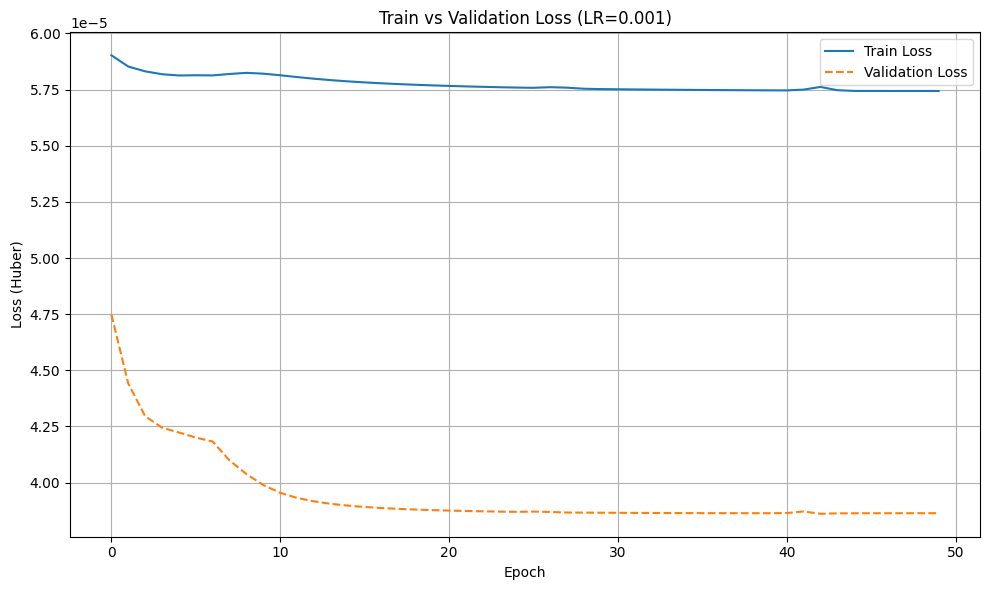

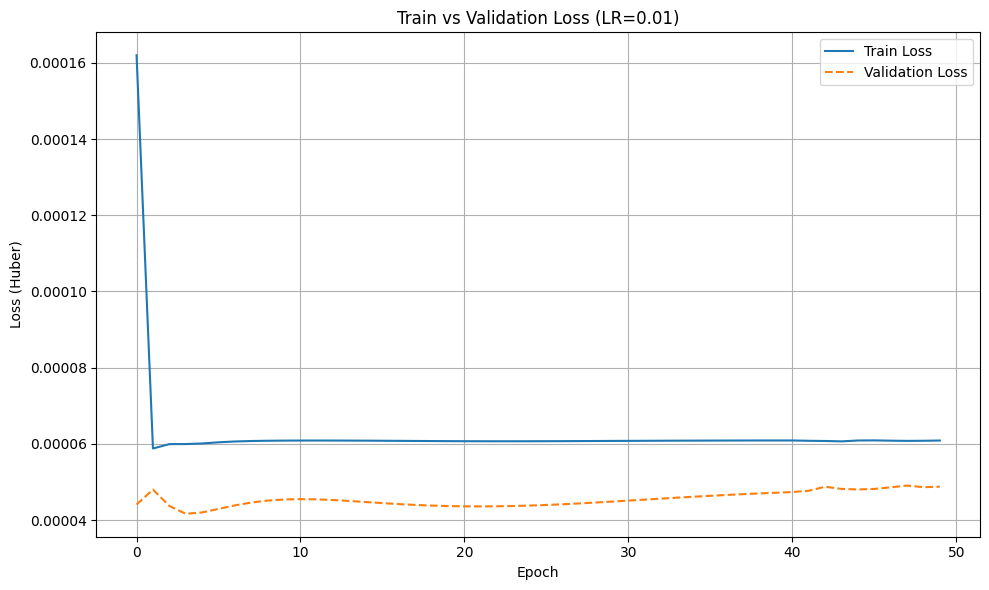

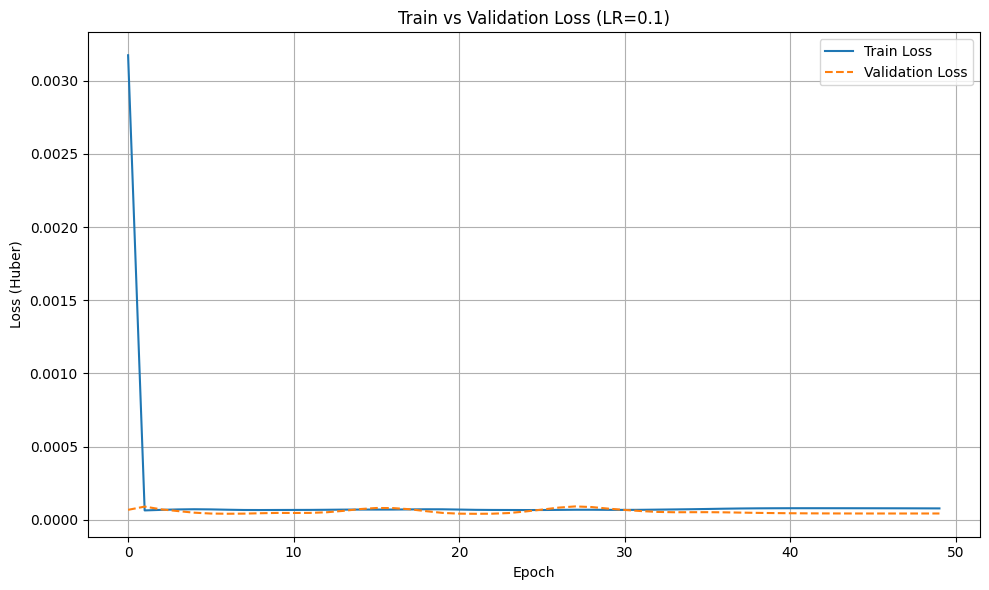

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
history_dict = {}

for lr in learning_rates:
    tf.random.set_seed(42)
    with tf.device('/GPU:0'):
        simple_model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(T, 1)),
            tf.keras.layers.LSTM(24),
            tf.keras.layers.Dense(1),
        ])

    simple_model.compile(loss='huber', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    print(f"\nTraining with learning rate: {lr}")
    r = simple_model.fit(
        x_train,
        y_train,
        epochs=50,
        validation_data=(x_test, y_test),
        verbose=0
    )
    history_dict[lr] = r.history

# Plotting in separate graphs
for lr in learning_rates:
    history = history_dict[lr]
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f'Train vs Validation Loss (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Huber)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We find that learning rate of 0.001 gives the loss v/s iteration graph

In [ ]:
tf.random.set_seed(42)
with tf.device('/GPU:0'):
    simple_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(T, 1)),
        tf.keras.layers.LSTM(24),
        tf.keras.layers.Dense(1),
    ])
simple_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 24)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

We have chosen learning rate as 0.1 as it showed the best convergence graph on tain loss and test loss though we might be at the risk of overfitting

In [ ]:
simple_model.compile(loss = 'huber', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [ ]:
r = simple_model.fit(
    x_train,
    y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.9603e-04 - val_loss: 4.7715e-05
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2791e-05 - val_loss: 4.9003e-05
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3012e-05 - val_loss: 4.8213e-05
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.2702e-05 - val_loss: 4.5183e-05
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.1976e-05 - val_loss: 4.2399e-05
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1538e-05 - val_loss: 4.1604e-05
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1749e-05 - val_loss: 4.1780e-05
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.2212e-05 - val_loss: 4.2367e-05
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.2694e-05 - val_loss: 4.3046e-05
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.3087e-05 - val_loss: 4.3628e-05
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.3364e-0

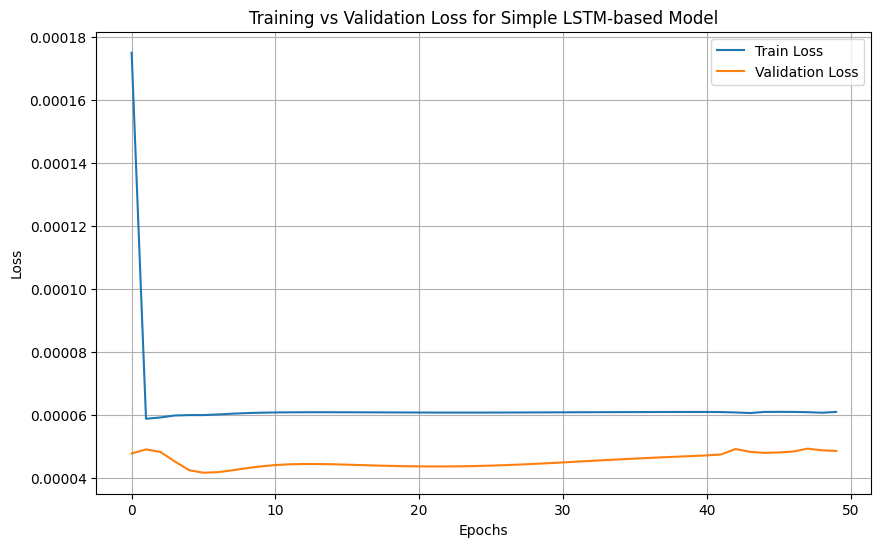

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss for Simple LSTM-based Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Forecasting the actual stock price movement is intrinsically unreliable, as it closely resembles a random walk (a pattern that is, by nature, unpredictable). This is evident from the graph: while the model performs well on the training set, it fails to generalize effectively to the test set. This suggests potential overfitting, where the model has learned patterns specific to the training data but not applicable to unseen data. Additionally, our simple_model demonstrates an out-of-sample problem, showing significantly reduced performance on the test set compared to the training set.

In [ ]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
predict_train = simple_model.predict(x_train).flatten()
predict_test = simple_model.predict(x_test).flatten()

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
df["ShiftLogClose"] = df["LogClose"].shift(1)
prev = df["ShiftLogClose"]
last_train = train.iloc[-1]["LogClose"]

In [ ]:
df.loc[train_idx, '1step_train'] = prev[train_idx]+ predict_train
df.loc[test_idx, '1step_test'] = prev[test_idx] + predict_test

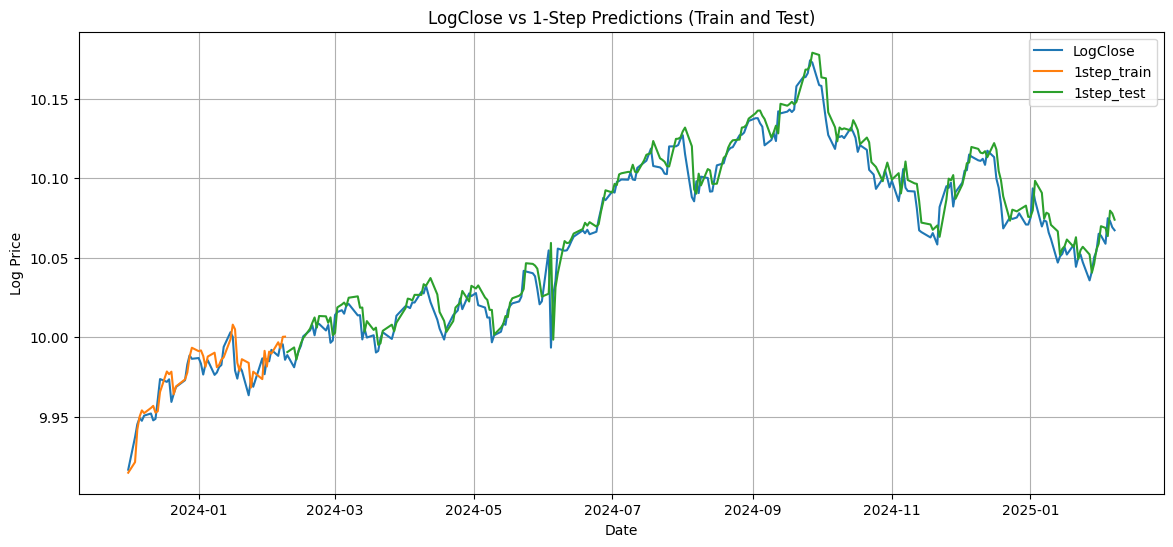

In [ ]:
df.loc[pd.to_datetime('2023-12-01').date():][['LogClose', '1step_train', '1step_test']].plot(figsize=(14, 6))
plt.title('LogClose vs 1-Step Predictions (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend()
plt.show()

What is happening is that model is somewhat tryinh to lag the returns

We now move forward with the model that predict multiple timestep values in the future

100%|██████████| 24/24 [07:14<00:00, 18.10s/it]


Top 10 Configurations by Validation Loss:
 Tx  Ty  units pooling    lr  epochs  val_loss                                      config
 20   3     32     avg 0.001      50  0.000001 Tx=20_Ty=3_units=32_pool=avg_lr=0.001_ep=50
 20   3     24     avg 0.001      50  0.000002 Tx=20_Ty=3_units=24_pool=avg_lr=0.001_ep=50
 20   3     24     avg 0.010      50  0.000003  Tx=20_Ty=3_units=24_pool=avg_lr=0.01_ep=50
 20   3     32     avg 0.010      50  0.000004  Tx=20_Ty=3_units=32_pool=avg_lr=0.01_ep=50
 30   3     32     avg 0.001      50  0.000006 Tx=30_Ty=3_units=32_pool=avg_lr=0.001_ep=50
 30   3     24     avg 0.001      50  0.000007 Tx=30_Ty=3_units=24_pool=avg_lr=0.001_ep=50
 20   3     32     avg 0.100      50  0.000007   Tx=20_Ty=3_units=32_pool=avg_lr=0.1_ep=50
 30   3     24     avg 0.010      50  0.000010  Tx=30_Ty=3_units=24_pool=avg_lr=0.01_ep=50
 30   3     32     avg 0.010      50  0.000010  Tx=30_Ty=3_units=32_pool=avg_lr=0.01_ep=50
 20   3     24     avg 0.100      50  0.000014  

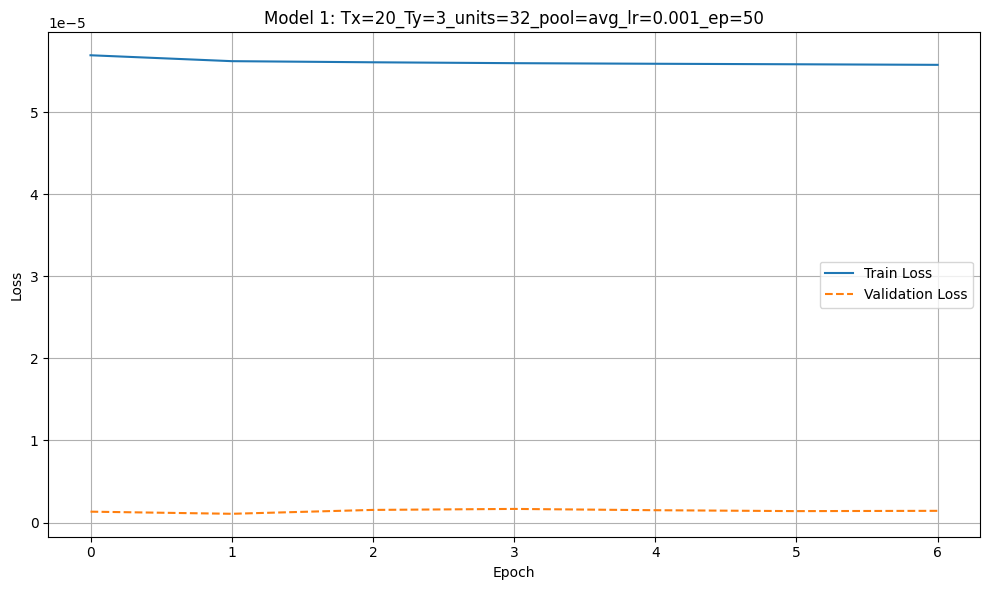

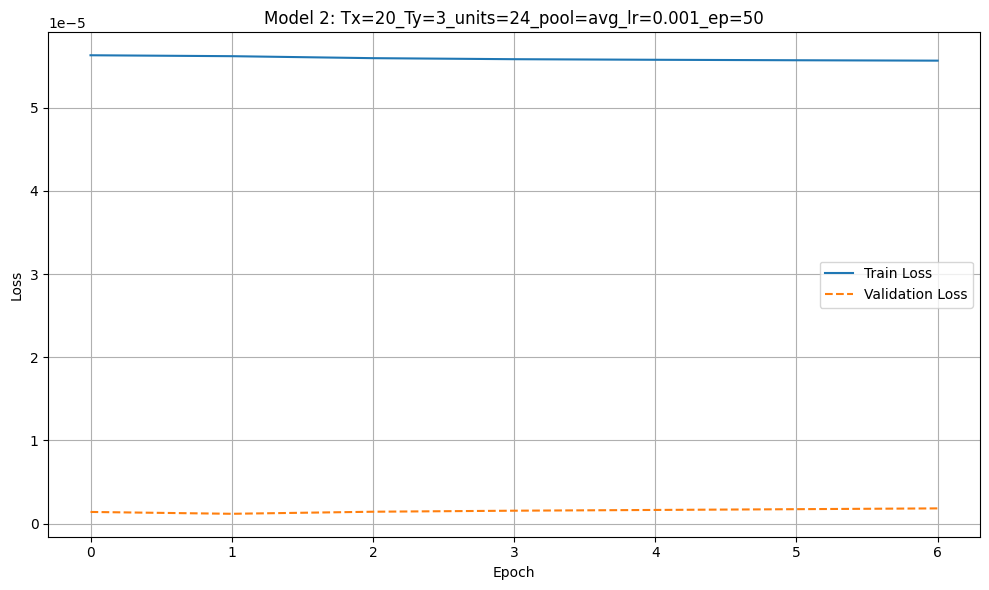

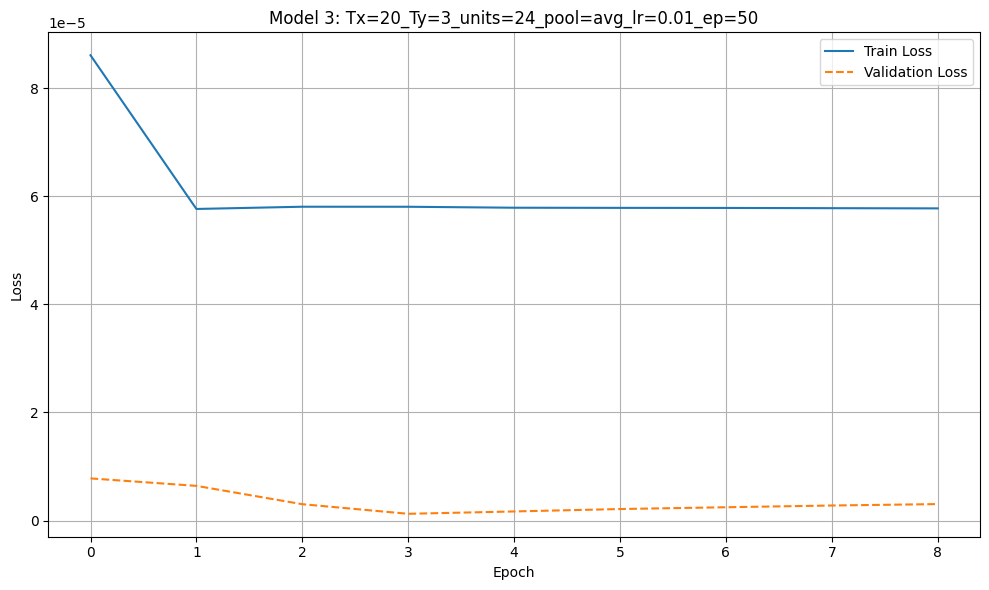

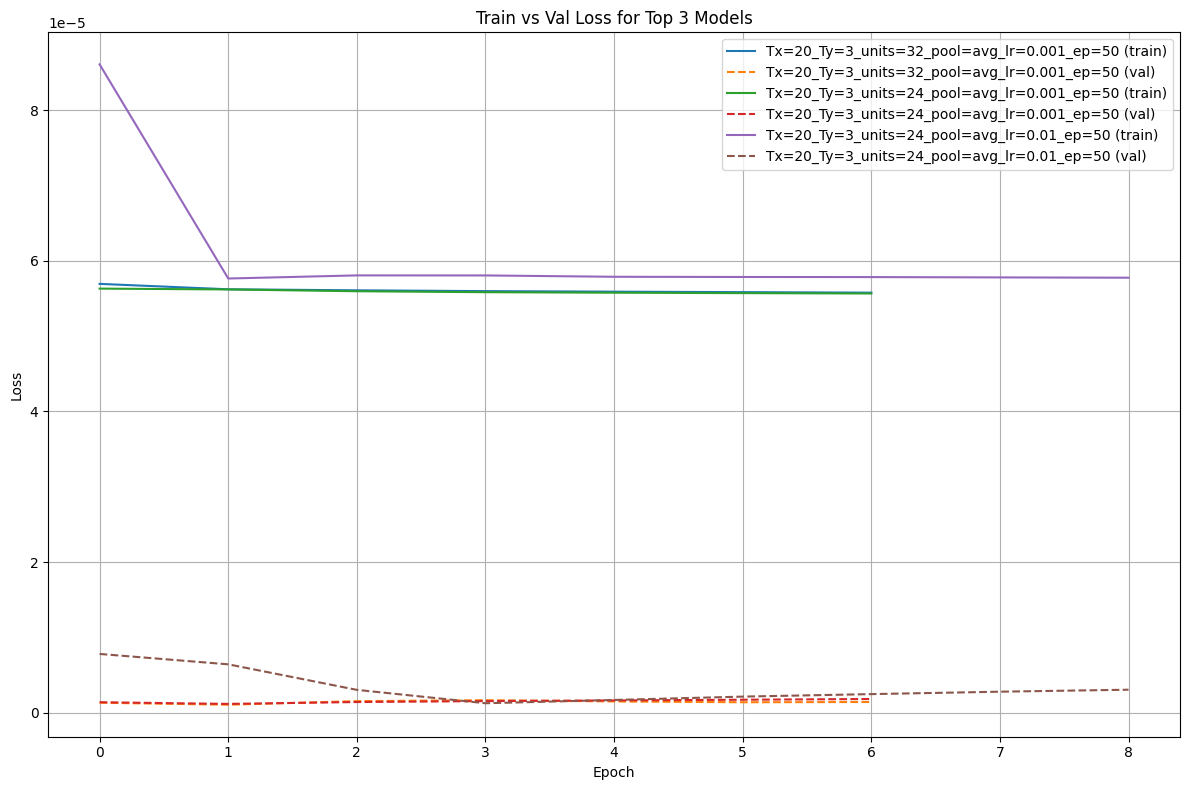

In [ ]:

# -------------------------------
# 1. Generate X, Y for given Tx, Ty
# -------------------------------
def generate_dataset(series, Tx, Ty):
    X, Y = [], []
    for t in range(len(series) - Tx - Ty + 1):
        x = series[t:t+Tx]
        y = series[t+Tx:t+Tx+Ty]
        X.append(x)
        Y.append(y)
    X = np.array(X).reshape(-1, Tx, 1)
    Y = np.array(Y).reshape(-1, Ty)
    return X, Y

# -------------------------------
# 2. Build model for config
# -------------------------------
def build_model(Tx, Ty, units, pooling_type, learning_rate):
    model = Sequential()
    model.add(Input(shape=(Tx, 1)))
    model.add(LSTM(units, return_sequences=True))

    if pooling_type == 'max':
        model.add(GlobalMaxPooling1D())
    elif pooling_type == 'avg':
        model.add(GlobalAveragePooling1D())

    model.add(Dense(Ty))

    model.compile(
        loss=Huber(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )
    return model

# -------------------------------
# 3. Hyperparameter Grid
# -------------------------------
Tx_values = [20, 30]
Ty_values = [3, 5]
units_list = [24, 32]
pooling_types = ['avg']
learning_rates = [0.1, 0.01, 0.001]
epoch_options = [50]

grid = [
    (Tx, Ty, units, pooling, lr, epochs)
    for Tx in Tx_values
    for Ty in Ty_values
    for units in units_list
    for pooling in pooling_types
    for lr in learning_rates
    for epochs in epoch_options
]

# -------------------------------
# 4. Grid Search Loop
# -------------------------------
results = []
history_dict = {}

for Tx, Ty, units, pooling, lr, epochs in tqdm(grid):
    X, Y = generate_dataset(series, Tx, Ty)
    no_test = 1
    x_train, y_train = X[:-no_test], Y[:-no_test]
    x_test, y_test = X[-no_test:], Y[-no_test:]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    model = build_model(Tx, Ty, units, pooling, lr)

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]

    config_name = f"Tx={Tx}_Ty={Ty}_units={units}_pool={pooling}_lr={lr}_ep={epochs}"
    results.append({
        'Tx': Tx,
        'Ty': Ty,
        'units': units,
        'pooling': pooling,
        'lr': lr,
        'epochs': epochs,
        'val_loss': val_loss,
        'config': config_name
    })

    history_dict[config_name] = history.history

# -------------------------------
# 5. Show Sorted Results
# -------------------------------
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='val_loss').reset_index(drop=True)

print("Top 10 Configurations by Validation Loss:")
print(results_df_sorted.head(10).to_string(index=False))

# -------------------------------
# 6A. Plot Individual Loss Curves for Top 3 Models
# -------------------------------
top_n = 3
for i in range(top_n):
    config = results_df_sorted.loc[i, 'config']
    history = history_dict.get(config)
    if history:
        plt.figure(figsize=(10, 6))
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], linestyle='--', label='Validation Loss')
        plt.title(f"Model {i+1}: {config}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# -------------------------------
# 6. Plot Top 3 Model Loss Curves
# -------------------------------
plt.figure(figsize=(12, 8))
top_n = 3
for i in range(top_n):
    config = results_df_sorted.loc[i, 'config']
    history = history_dict.get(config)
    if history:
        plt.plot(history['loss'], label=f'{config} (train)')
        plt.plot(history['val_loss'], linestyle='--', label=f'{config} (val)')

plt.title(f"Train vs Val Loss for Top {top_n} Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2. Multioutput Model which predicts 3 timesteps in the future

In [ ]:
# Make multi-output supervised dataset
Tx = 20     #Prediction based on 20 past values
Ty = 3
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2483, 20, 1) Y.shape (2483, 3)


In [ ]:
test_cases = 250
x_train_multi, y_train_multi = X[:-test_cases], Y[:-test_cases]
x_test_multi, y_test_multi = X[-test_cases:], Y[-test_cases:]

In [ ]:
multioutput_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(Tx, 1)),
    tf.keras.layers.LSTM(24, return_sequences= True ),
    tf.keras.layers.GlobalMaxPooling1D(), # Added pooling layer
    tf.keras.layers.Dense(Ty)
])
multioutput_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 20, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 24)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,571 (10.04 KB)

 Trainable params: 2,571 (10.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
check_point = ModelCheckpoint("best_multioutput_model.keras", monitor = 'val_loss', save_best_only = True)

In [ ]:
multioutput_model.compile(
    loss = 'huber',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
)

In [ ]:
r = multioutput_model.fit(
    x_train_multi,
    y_train_multi,
    epochs = 50,
    validation_data = (x_test_multi, y_test_multi),
    callbacks = [check_point]
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 5.5049e-05 - val_loss: 4.0127e-05
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4028e-05 - val_loss: 4.0309e-05
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4051e-05 - val_loss: 3.9829e-05
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4163e-05 - val_loss: 3.9162e-05
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.4227e-05 - val_loss: 3.9110e-05
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3852e-05 - val_loss: 3.8985e-05
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3776e-05 - val_loss: 3.8952e-05
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.3759e-05 - val_loss: 3.8926e-05
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.3802e-05 - val_loss: 3.8905e-05
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.3703e-05 - val_loss: 3.8921e-05
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3737e-0

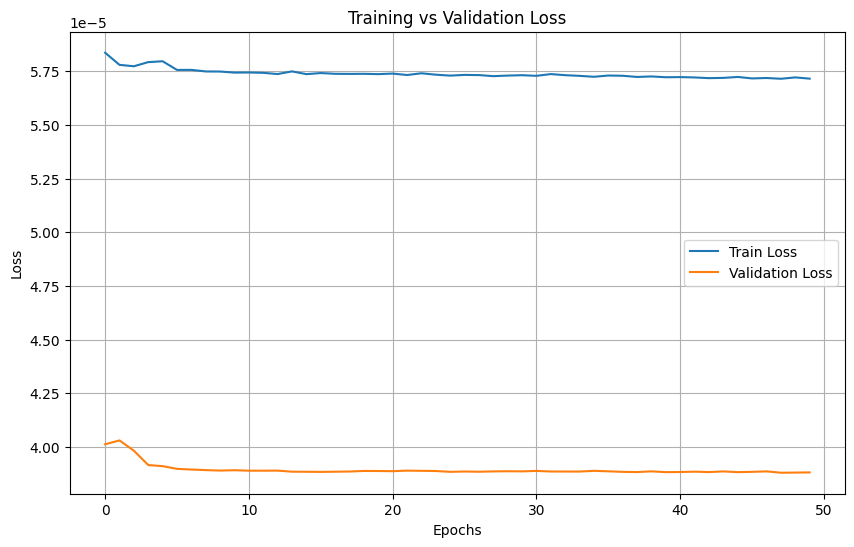

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_multioutput_model = tf.keras.models.load_model("best_multioutput_model.keras")

In [ ]:
predict_train = multioutput_model.predict(x_train_multi)
predict_test = multioutput_model.predict(x_test_multi)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [ ]:
predict_train = predict_train[:,0]
predict_test = predict_test[:,0]

In [ ]:
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(predict_test)

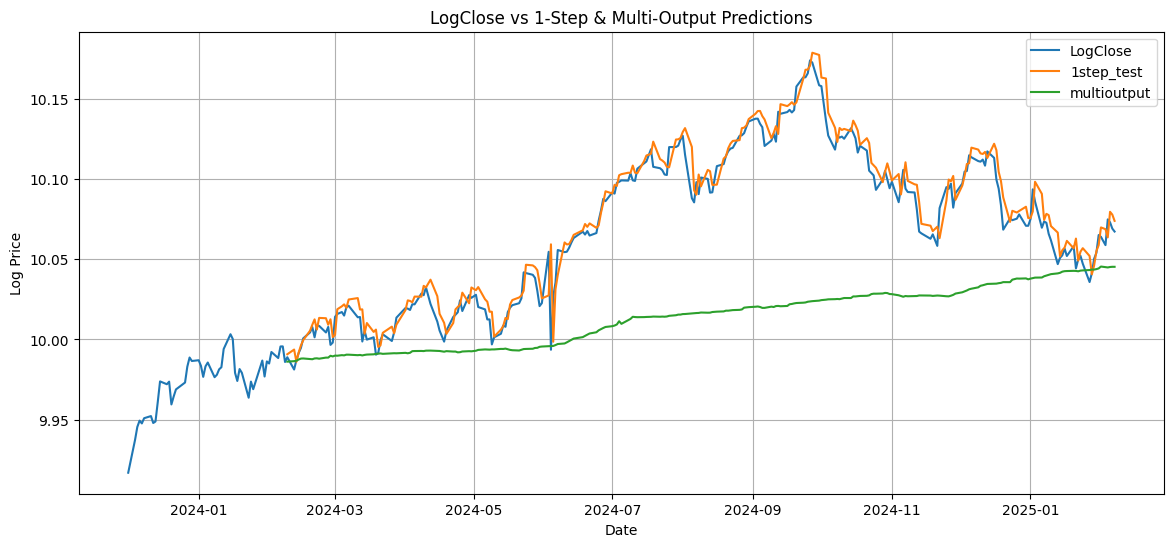

In [ ]:
df.loc[pd.to_datetime('2023-12-01').date():][['LogClose', '1step_test', 'multioutput']].plot(figsize=(14, 6))
plt.title('LogClose vs 1-Step & Multi-Output Predictions')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend()
plt.show()

Here, the multioutput model has picked up the general upward trend of Nifty50 because of the way model is defined and trained

In [ ]:
def generate_dataset(series, Tx, Ty):
    X, Y = [], []
    for t in range(len(series) - Tx - Ty + 1):
        x = series[t:t+Tx]
        y = series[t+Tx:t+Tx+Ty]
        X.append(x)
        Y.append(y)
    X = np.array(X).reshape(-1, Tx, 1)
    Y = np.array(Y).reshape(-1, Ty)
    return X, Y

def build_model(Tx, Ty, lstm1, lstm2, dropout, pooling):
    model = Sequential()
    model.add(Input(shape=(Tx, 1)))
    model.add(LSTM(lstm1, return_sequences=True))
    if dropout:
        model.add(Dropout(dropout))
    model.add(LSTM(lstm2, return_sequences=True))
    if dropout:
        model.add(Dropout(dropout))
    if pooling == 'max':
        model.add(GlobalMaxPooling1D())
    else:
        model.add(GlobalAveragePooling1D())
    model.add(Dense(Ty))
    return model


In [ ]:
tx_ty_pairs = {
    1: (20, 3)
}

lstm_combos = [(24, 24), (32, 24)]
dropouts = [None, 0.2, 0.3]
lrs = [0.1, 0.01, 0.001]
epochs_list = [50]
pooling = 'max'

results_all = []
history_dict_all = {}

In [ ]:
for block in range(1, 2):
    Tx, Ty = tx_ty_pairs[block]
    print(f"\n=== Running Block {block}: Tx={Tx}, Ty={Ty} ===")
    X, Y = generate_dataset(series, Tx, Ty)
    x_train, y_train = X[:-test_cases], Y[:-test_cases]
    x_test, y_test = X[-test_cases:], Y[-test_cases:]

    for (lstm1, lstm2) in lstm_combos:
        for do in dropouts:
            for lr in lrs:
                for ep in epochs_list:
                    tf.keras.backend.clear_session()
                    tf.random.set_seed(42)
                    model = build_model(Tx, Ty, lstm1, lstm2, do, pooling)
                    model.compile(loss=Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

                    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                    history = model.fit(
                        x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=ep,
                        verbose=0,
                        callbacks=[early_stop]
                    )

                    best_val = min(history.history['val_loss'])
                    final_val = history.history['val_loss'][-1]
                    config_id = f"block{block}_Tx{Tx}_Ty{Ty}_lstm1{lstm1}_lstm2{lstm2}_do{do}_lr{lr}_ep{ep}"

                    results_all.append({
                        'config': config_id,
                        'Tx': Tx,
                        'Ty': Ty,
                        'LSTM1': lstm1,
                        'LSTM2': lstm2,
                        'Dropout': do,
                        'LR': lr,
                        'Epochs': ep,
                        'Best_Val_Loss': best_val,
                        'Last_Val_Loss': final_val
                    })

                    history_dict_all[config_id] = history.history



=== Running Block 1: Tx=20, Ty=3 ===


In [ ]:
results_df = pd.DataFrame(results_all)
results_df_sorted = results_df.sort_values(by='Best_Val_Loss').reset_index(drop=True)
results_df_sorted.to_csv("multiLSTM_results.csv", index=False)


In our hyperparameter tuning experiments, we explored a wide range of configurations varying learning rates, dropout rates, sequence lengths (Tx), prediction horizons (Ty), LSTM units, and epochs.
Models with moderate sequence lengths (Tx = 30) and shorter prediction horizons (Ty = 2 or 3) generally achieved lower validation losses, while excessively large models tended to overfit. Configurations with smaller LSTM units (24 or 32) paired with low learning rates (0.001 or 0.01) consistently performed well, especially when combined with dropout rates between 0.2 and 0.3 to control overfitting. We also observed that high learning rates (0.1) often led to rapid overfitting, evident from large gaps between the best and last validation losses.

Based on these results, we have finalized the following hyperparameters to achieve balanced generalization and performance while avoiding overfitting: learning rate = 0.01
dropout = 0.2
sequence length (Tx) = 20
prediction horizon (Ty) = 3
LSTM layers = 24 units each
training epochs = 50

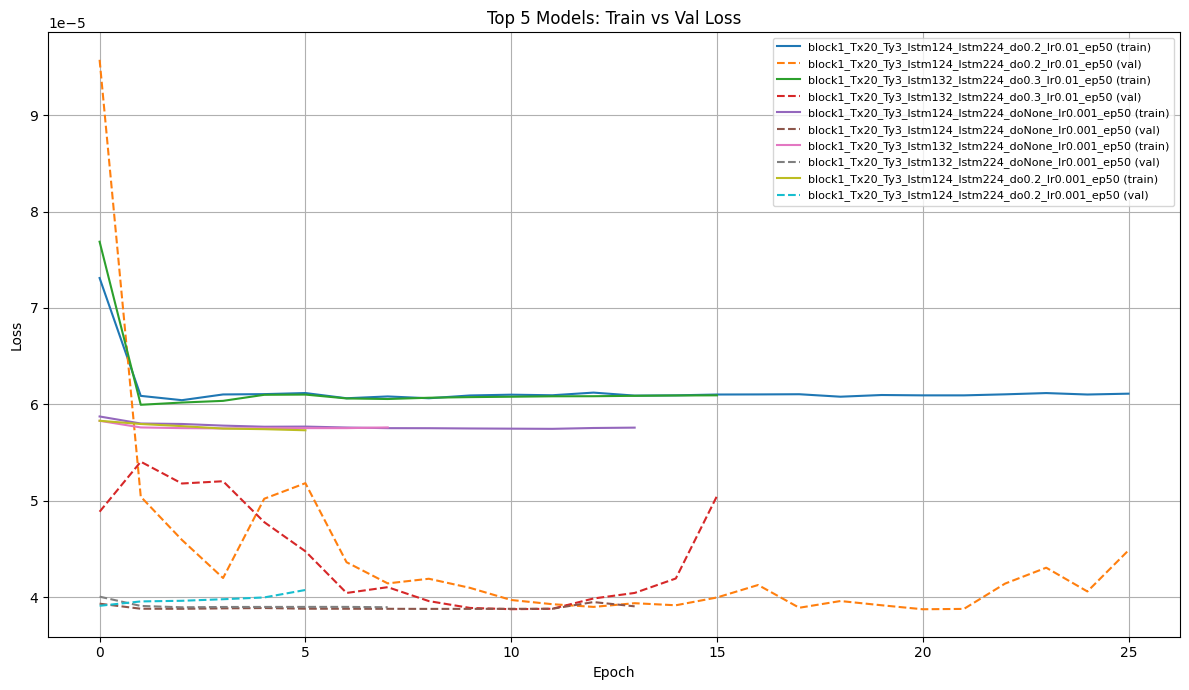

In [ ]:
plt.figure(figsize=(12, 7))
for i in range(min(5, len(results_df_sorted))):
    row = results_df_sorted.iloc[i]
    key = row['config']
    hist = history_dict_all[key]
    plt.plot(hist['loss'], label=f'{key} (train)')
    plt.plot(hist['val_loss'], label=f'{key} (val)', linestyle='--')

plt.title("Top 5 Models: Train vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


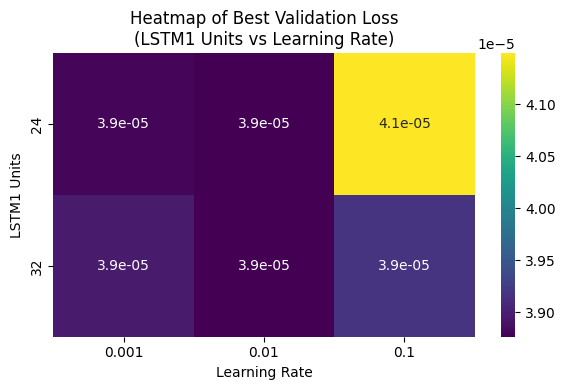

In [ ]:
pivot_table = results_df.pivot_table(
    index='LSTM1',
    columns='LR',
    values='Best_Val_Loss',
    aggfunc='min'
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_table, annot=True, fmt=".1e", cmap="viridis")
plt.title("Heatmap of Best Validation Loss\n(LSTM1 Units vs Learning Rate)")
plt.ylabel("LSTM1 Units")
plt.xlabel("Learning Rate")
plt.tight_layout()
plt.show()

The heatmap clearly shows that models with smaller LSTM layers (24 units)  achieve lower validation losses across all learning rates tested, indicating better generalization and robustness.

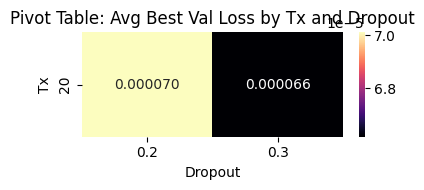

In [ ]:
pivot_table2 = results_df.pivot_table(
    index='Tx',
    columns='Dropout',
    values='Best_Val_Loss',
    aggfunc='mean'
)

plt.figure(figsize=(4, 2))
sns.heatmap(pivot_table2, annot=True, fmt=".6f", cmap="magma")
plt.title("Pivot Table: Avg Best Val Loss by Tx and Dropout")
plt.ylabel("Tx")
plt.xlabel("Dropout")
plt.tight_layout()
plt.show()

This heatmap shows that shorter sequence lengths (Tx = 20) consistently result in the lowest  validation losses, indicating better model  and generalization for smaller input sequences. Specifically, Tx = 20 with a dropout rate of 0.2 yields the lowest loss, while increasing dropout slightly increases the loss but still keeps it significantly lower than higher Tx values.

In [ ]:
results_df_sorted = pd.read_csv("multiLSTM_results.csv")

results_df_sorted.to_csv("multiLSTM_results.csv", index=False)

# Save as Excel
excel_path = "multiLSTM_results.xlsx"
results_df_sorted.to_excel(excel_path, index=False)
print(f"Saved to {excel_path}")
# files.download("multiLSTM_results.xlsx")

Saved to multiLSTM_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tf.random.set_seed(42)
with tf.device('/GPU:0'):
    multioutput_model2 = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(Tx, 1)),  # Explicitly add the Input layer
        tf.keras.layers.LSTM(24, return_sequences=True),
        tf.keras.layers.LSTM(20, return_sequences= True ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(Ty),
    ])
multioutput_model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 20, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 20, 20)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 20)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,159 (24.06 KB)

 Trainable params: 6,159 (24.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
check_point = ModelCheckpoint("best_multioutpu2_model.keras", monitor = 'val_loss', save_best_only = True)

In [ ]:
multioutput_model2.compile(loss = 'huber', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

In [ ]:
r = multioutput_model2.fit(
    x_train_multi,
    y_train_multi,
    epochs = 50,
    validation_data = (x_test_multi, y_test_multi),
    callbacks = [check_point]
)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 5.5337e-05 - val_loss: 4.4691e-05
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 5.3905e-05 - val_loss: 4.4476e-05
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.3887e-05 - val_loss: 4.3846e-05
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.3826e-05 - val_loss: 4.3283e-05
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.3794e-05 - val_loss: 4.2503e-05
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3690e-05 - val_loss: 4.1490e-05
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.3647e-05 - val_loss: 4.2262e-05
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3587e-05 - val_loss: 4.0819e-05
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.3587e-05 - val_loss: 4.0495e-05
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.3517e-05 - val_loss: 4.0472e-05
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.3656e-0

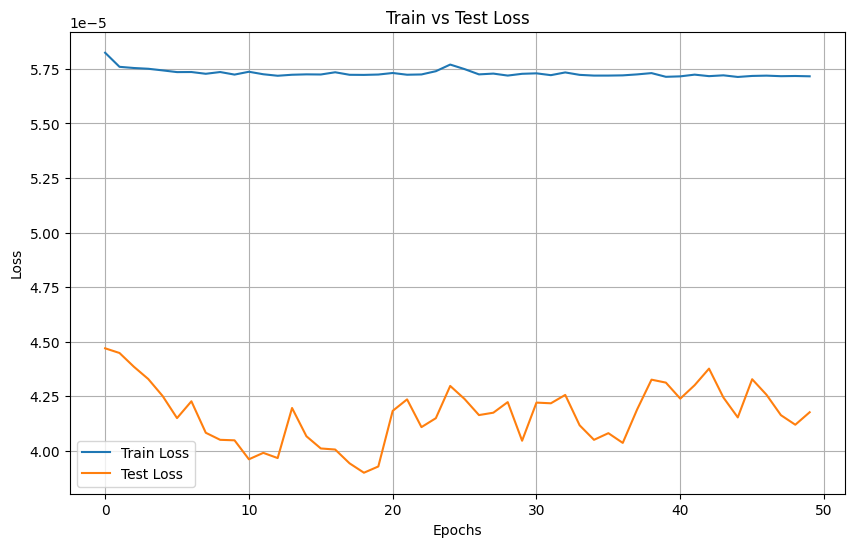

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Test Loss')
plt.title('Train vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_multioutput2_model = tf.keras.models.load_model('best_multioutpu2_model.keras')

In [ ]:
predict_train = multioutput_model2.predict(x_train_multi)
predict_test = multioutput_model2.predict(x_test_multi)
predict_train = predict_train[:,0]
predict_test = predict_test[:,0]

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Flag 1

In [ ]:
multioutput_test_idx = df.index >= df.index[-test_cases]

df.loc[test_idx, 'multioutput2'] = last_train + np.cumsum(predict_test)


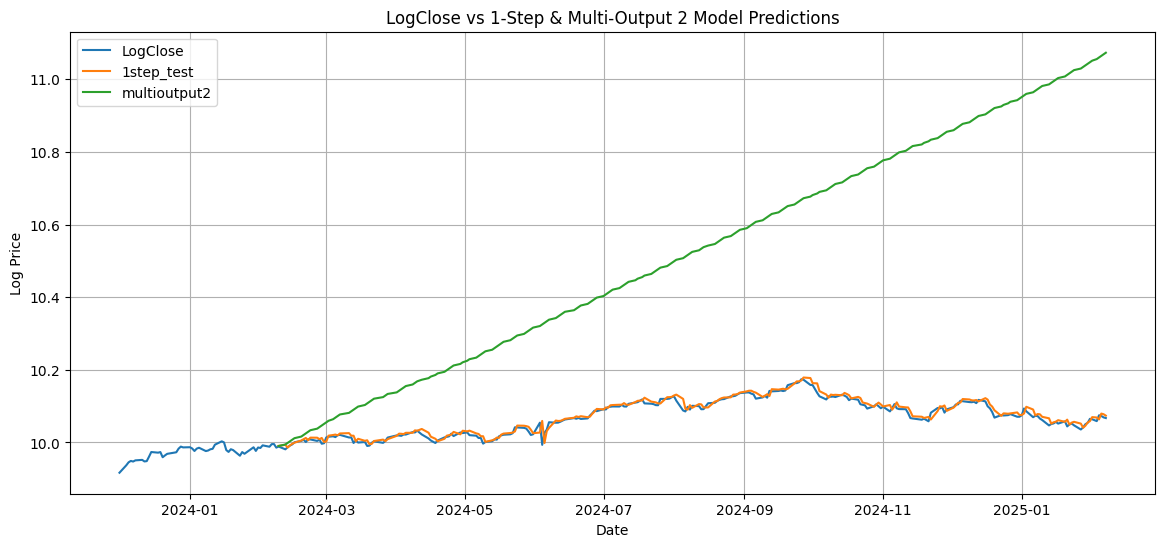

In [ ]:
df.loc[pd.to_datetime('2023-12-01').date():][['LogClose', '1step_test', 'multioutput2']].plot(figsize=(14, 6))
plt.title('LogClose vs 1-Step & Multi-Output 2 Model Predictions')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.grid(True)
plt.legend()
plt.show()

We see that these models when predicting for future timesteps generates constant mean values and  flatlines in the graph because of the way these models are structured.  

In [ ]:
# Custom sMAPE function
def sMAPE(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Replace these with actual test ground truths and model predictions
y_true = df.loc[test_idx, 'LogClose']
y_pred_1step = df.loc[test_idx, '1step_test']
y_pred_multioutput = df.loc[test_idx, 'multioutput']
y_pred_multioutput2 = df.loc[test_idx, 'multioutput2']

def compute_metrics(y_true, y_pred):
    return [
        mean_absolute_error(y_true, y_pred),
        r2_score(y_true, y_pred),
        mean_absolute_percentage_error(y_true, y_pred) * 100,
        sMAPE(y_true, y_pred),
        np.sum((y_true - y_pred) ** 2)
    ]

# Create metrics table
metrics_table = {
    'Metric': ['MAE', 'R2 Score', 'MAPE (%)', 'sMAPE (%)', 'SSE'],
    '1step-forecast': [f"{v:.4f}" for v in compute_metrics(y_true, y_pred_1step)],
    'multioutput': [f"{v:.4f}" for v in compute_metrics(y_true, y_pred_multioutput)],
    'multioutput2': [f"{v:.4f}" for v in compute_metrics(y_true, y_pred_multioutput2)],
}

metrics_df = pd.DataFrame(metrics_table)
metrics_df.set_index('Metric', inplace=True)
metrics_naive_df = metrics_naive_df.rename(columns={'Value': 'Naive forecast'})
metrics_combined_df = pd.concat([metrics_naive_df.set_index('Metric'), metrics_df], axis=1)
print("\nFinal Combined Metrics Table:")
print(metrics_combined_df.to_string())


Final Combined Metrics Table:
          Naive forecast 1step-forecast multioutput multioutput2
Metric                                                          
MAE              92.8873         0.0070      0.0569       0.4606
R2 Score          0.9993         0.9567     -1.0927    -130.5922
MAPE (%)          0.7082         0.0699      0.5634       4.5666
sMAPE (%)         0.7076         0.0699      0.5657       4.4267
SSE        46512072.4743         0.0243      1.1732      73.7747


1step-forecast model dramatically outperforms all other models: lowest error, highest R², most stable.

multioutput and multioutput2 struggle because predicting multiple future steps is harder, likely with current model size/hyperparameters.

Naive forecast fails by having massive absolute errors, even if its R² looks superficially high (a misleading artifact when series trend dominates).

1. walk-forward validation to optimize hyperparameters?

In [ ]:
# MAPE
test_log_pass = df.iloc[-test_cases:]['LogClose']
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-output MAPE: 0.0056343305068183
multi-output (2 LSTMs) MAPE: 0.04566623657862334


Increasing the complexity seems to have reduced the performace of the model

In [ ]:
df_results_sorted = results_df_sorted.copy()
csv_filename = "multiLSTM_results_for_download.csv"
df_results_sorted.to_csv(csv_filename, index=False)

# Download the CSV file
from google.colab import files
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.tail()

,close,LogClose,DiffLogClose,ShiftLogClose,1step_train,1step_test,multioutput,multioutput2
date,,,,,,,,
2025-02-03,23361.05,10.058825,-0.005170,10.063996,NaN,10.068794,10.045082,11.055601
2025-02-04,23739.25,10.074885,0.016060,10.058825,NaN,10.063642,10.044900,11.060022
2025-02-05,23696.30,10.073074,-0.001811,10.074885,NaN,10.079626,10.045180,11.064356
2025-02-06,23603.35,10.069144,-0.003930,10.073074,NaN,10.077872,10.045297,11.068710
2025-02-07,23559.95,10.067304,-0.001840,10.069144,NaN,10.073956,10.045290,11.073090


In [ ]:
end_date = date.today()
start_date = end_date - timedelta(days=57)
last30_df = yf.download("^NSEI", start=start_date, end=end_date)
print(f"Downloaded data for Nifty 50 from {start_date} to {end_date}")
print(last30_df.head())
print(f"Number of days downloaded: {len(last30_df)}")

/tmp/ipython-input-418-198536935.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  last30_df = yf.download("^NSEI", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded data for Nifty 50 from 2025-05-18 to 2025-07-14
Price              Close          High           Low          Open  Volume
Ticker             ^NSEI         ^NSEI         ^NSEI         ^NSEI   ^NSEI
Date                                                                      
2025-05-19  24945.449219  25062.949219  24916.650391  25005.349609  255300
2025-05-20  24683.900391  25010.349609  24669.699219  24996.199219  414800
2025-05-21  24813.449219  24946.199219  24685.349609  24744.250000  332700
2025-05-22  24609.699219  24737.500000  24462.400391  24733.949219  403300
2025-05-23  24853.150391  24909.050781  24614.050781  24639.500000  270500
Number of days downloaded: 40


In [ ]:
columns_to_drop = ['High', 'Low', 'Open', 'Volume']
existing_columns_to_drop = [col for col in columns_to_drop if col in last30_df.columns]
if existing_columns_to_drop:
    last30_df.drop(existing_columns_to_drop, axis = 1, inplace = True)

last30_df.columns = last30_df.columns.droplevel(1)
last30_df.rename(columns = {'Date': 'date', 'Close': 'close'}, inplace = True)

last30_df["LogClose"] = np.log(last30_df["close"])
last30_df["DiffLogClose"] = last30_df["LogClose"].diff()

last30_df.head()

Price,close,LogClose,DiffLogClose
Date,,,
2025-05-19,24945.449219,10.124447,NaN
2025-05-20,24683.900391,10.113907,-0.010540
2025-05-21,24813.449219,10.119141,0.005235
2025-05-22,24609.699219,10.110896,-0.008245
2025-05-23,24853.150391,10.120740,0.009844


In [ ]:
series_last30 = last30_df["DiffLogClose"].dropna().to_numpy()
X_last30 = []

if len(series_last30) >= T:
    for t in range(len(series_last30) - T + 1):
        x = series_last30[t:t+T]
        X_last30.append(x)

    X_last30 = np.array(X_last30).reshape(-1, T, 1)

    # Make predictions using the simple_model
    predict_last30 = simple_model.predict(X_last30).flatten()

    print("Predictions for the last 30 days generated successfully.")
else:
    print(f"Not enough data points ({len(series_last30)}) in the last 30 days to create sequences of length {T}.")
    predict_last30 = np.array([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predictions for the last 30 days generated successfully.


In [ ]:
last30_df["ShiftLogClose"] = last30_df["LogClose"].shift(1)
prev = last30_df["ShiftLogClose"]
last_train = train.iloc[-1]["LogClose"]

In [ ]:
no_test_for_last30 = 20
train_30 = last30_df.iloc[:-no_test]
test_30 = last30_df.iloc[-no_test:]
test_idxs = last30_df.index > train_30.index[-1]

In [ ]:
last30_df.loc[test_idxs, 'Predicted_LogClose'] = prev[test_idxs] + predict_last30
last30_df['predicted_close'] = np.exp(last30_df['Predicted_LogClose'])
last30_df.tail()

Price,close,LogClose,DiffLogClose,ShiftLogClose,Predicted_LogClose,predicted_close
Date,,,,,,
2025-07-07,25461.300781,10.144915,0.000012,10.144903,10.149696,25583.312330
2025-07-08,25522.500000,10.147316,0.002401,10.144915,10.149700,25583.422014
2025-07-09,25476.099609,10.145496,-0.001820,10.147316,10.152115,25645.294280
2025-07-10,25355.250000,10.140741,-0.004755,10.145496,10.150307,25598.972602
2025-07-11,25149.849609,10.132607,-0.008134,10.140741,10.145565,25477.845636


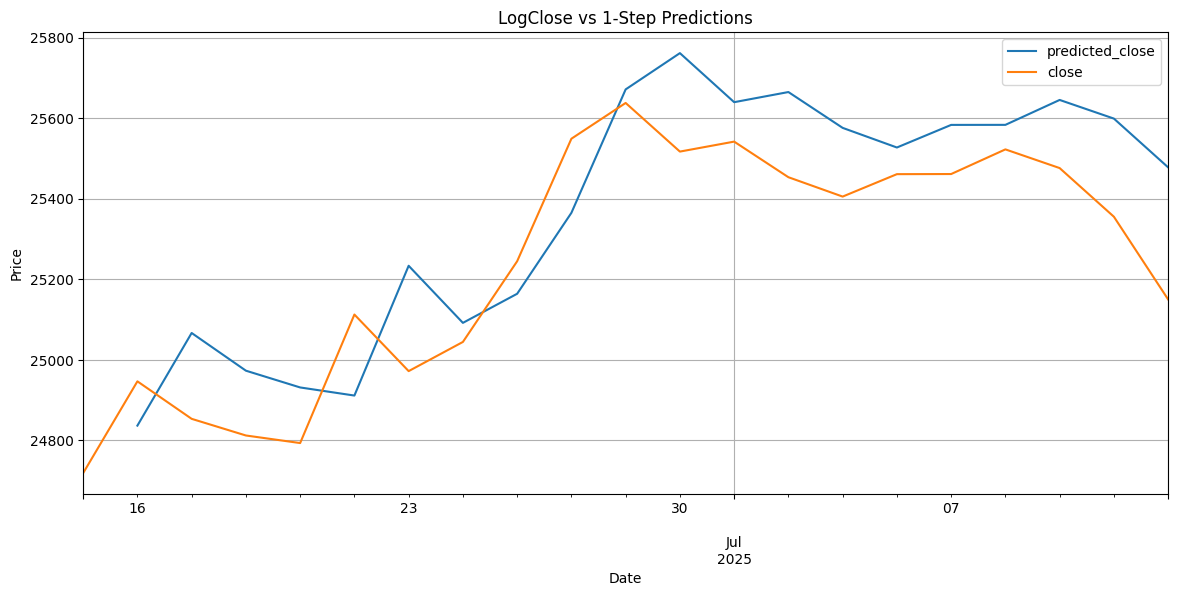

In [ ]:
last30_df.loc[pd.to_datetime('2025-6-13').date():][['predicted_close', 'close']].plot(figsize=(14, 6))
plt.title('LogClose vs 1-Step Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
csv_filename = "last30_df.csv"
last30_df.to_csv(csv_filename, index=True)
# files.download(csv_filename)